In [1]:
from Functions import *
import scipy.interpolate as interpolate

In [2]:
def load_data(num):
    coords = np.loadtxt('N_list.txt', skiprows=1)
    data = np.loadtxt('Uy_list_%d.txt' % num, skiprows=1)

    x = coords[:,1]
    y = coords[:,2]
    z = coords[:,3]
    dy = data[:,1]
    print(data.shape)
    # plt.figure()
    # plt.plot(x)
    # plt.figure()
    # plt.plot(z)

    xx = np.linspace(np.min(x), np.max(x), 1024)
    zz = np.linspace(np.min(z), np.max(z), 1024)
    xx,zz = np.meshgrid(xx,zz)

    # f = interpolate.interp2d(z,x,dy)
    dy2 = interpolate.griddata((x,z),dy,(xx,zz), fill_value=0)

    dy_symmetrize = np.concatenate((dy2,np.flipud(dy2)),axis=0)
    dy_symmetrize = np.concatenate((dy_symmetrize,np.fliplr(dy_symmetrize)),axis=1)

    xx2 = np.linspace(np.min(x), -np.min(x), 2048)
    zz2 = np.linspace(np.min(z), -np.min(z), 2048)
    xx2,zz2 = np.meshgrid(xx2,zz2)
    
    return dy_symmetrize, xx2, zz2

def plot_data(num, dy, xx, zz):
    plt.figure(figsize=(7 ,6))
    ax_im = plt.subplot2grid((6,7), (1,0), colspan=5, rowspan=3)
    ax_x = plt.subplot2grid((6,7), (4,0), colspan=5, rowspan=2)
    ax_y = plt.subplot2grid((6,7), (1,5), colspan=2, rowspan=3)
    ax_colorbar = plt.subplot2grid((6,7), (4,5), colspan=1, rowspan=2)
    im_profile = ax_im.imshow(dy*1e6+125, extent=(-7.5,7.5,-.75,.75),aspect=(20/4))
    ax_im.set_xlabel('Tangential coordinates (mm)')
    ax_im.set_ylabel('Sagittal coordinates (mm)')
    ax_x.plot(xx[0,:],dy[1024,:]*1e6+125)
    ax_x.set_ylabel('Height (nm)')
    ax_x.grid()
    ax_y.plot(dy[:,1024]*1e6+125,zz[:,0])
    ax_y.set_xlabel('Height (nm)')
    ax_y.grid()
    plt.colorbar(im_profile, cax=ax_colorbar, label='Height error (nm)')
    ax_im.set_title('Case %d' % num)


(3947, 2)
(3947, 2)
(3947, 2)


Text(0, 0.5, 'y (nm)')

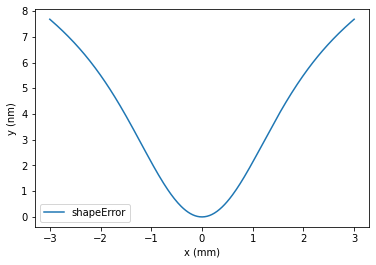

In [3]:
dy1, xx, zz = load_data(1)
dy2, xx, zz = load_data(2)
dy3, xx, zz = load_data(3)
shapes = [None,dy1*1e6,dy2*1e6,dy3*1e6]

theta = 800e-9/np.pi/200e-6

x = np.linspace(-3e-3,3e-3,2048)

plt.figure()
plt.plot((x*1e3), dy1[1024,:]*1e6, label='shapeError')
# plt.plot(x*1e3,x**2/(2*600)*1e9)
plt.legend()
plt.xlabel('x (mm)')
plt.ylabel('y (nm)')


In [4]:
''' Beam parameters '''
N = 1024			# number of sampling points
E0 = 9481			# photon energy [eV]
tau = 400			# pulse duration [fs]
window = 50000		# total simulation time window [fs]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
	'photonEnergy': E0,
	'N': N,
	'sigma_x': 23e-6,
	'sigma_y': 23e-6,
	'rangeFactor': 5,
	'scaleFactor': 10,
	'z_source': 650-26
}

In [5]:
##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_ev = dir_out + '{}eV/'.format(E0); make_dir(dir_ev)


path exists
path exists


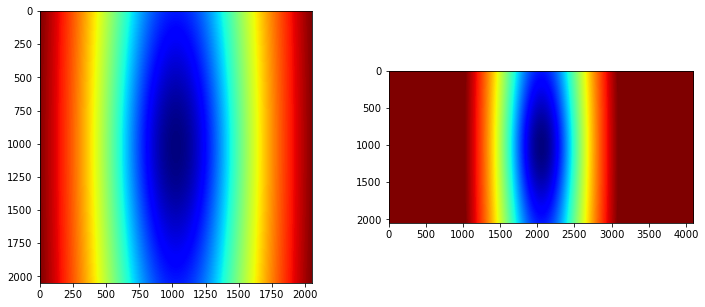

In [6]:
##### Padding
shape = shapes[1]

shapeError_x = (xx.max() - xx.min())*1e-3; dx = (xx[0,1]-xx[0,0])*1e-3
shapeError_y = (zz.max() - zz.min())*1e-3; dy = (zz[1,0]-zz[0,0])*1e-3

l_crystal = [3e-2 for i in range(4)]    # HRM crystal lengths (long)
w_crystal = [shapeError_y for i in range(4)]    # HRM crystal widths (short)

size_x_padded = np.int(l_crystal[0]/dx) + 1; size_x_padded = size_x_padded + size_x_padded%2
size_y_padded = np.int(w_crystal[0]/dy) + 1; size_y_padded = size_y_padded + size_y_padded%2

shapeError = np.ones((size_x_padded, size_y_padded)) * shape.max()
roi_x_i = int((size_x_padded - shape.shape[0])/2)
roi_x_f = roi_x_i + shape.shape[0]
roi_y_i = int((size_y_padded - shape.shape[1])/2)
roi_y_f = roi_y_i + shape.shape[1]

shapeError[roi_x_i:roi_x_f, roi_y_i:roi_y_f] = shape.T
shapeError = shapeError.T

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(shape, cmap='jet')

plt.subplot(1,2,2)
plt.imshow(shapeError, cmap='jet')


In [7]:
def define_beamline(
    E0, slit_width, m2_p=175.332, shape=None):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=256)
    
    ## Telescope
    m1 = optics.CurvedMirror('m1',p=185,q=-58,length=1,z=185+z_s,alpha=2.65e-3)
    im_after_T1 = optics.PPM('im_after_T1', z=m1.z+.01, FOV=5e-3, N=256)
    
    m2 = optics.CurvedMirror('m2',p=m2_p,q=1e5,length=1,z=300+z_s,alpha=2.65e-3,orientation=2)
    im_after_T2 = optics.PPM('im_after_T2', z=m2.z+.01, FOV=5e-3, N=256)
    
    ## HHLM
    asym = np.deg2rad(17)
    hhlm1 = optics.Crystal('HHLM1', hkl=[2,2,0], length=.1, width=20e-3, z=305+z_s, alphaAsym=-asym, E0=E0, 
                        orientation=0, pol='s')
    im_after_HHLM1 = optics.PPM('im_after_HHLM1', FOV=30e-3,N=256,z=hhlm1.z+.01)
    
    hhlm2 = optics.Crystal('HHLM2', hkl=[4,4,0], length=.1, width=20e-3, z=hhlm1.z+139e-3, E0=E0, orientation=2, pol='s')
    im_after_HHLM2 = optics.PPM('im_after_HHLM2', FOV=30e-3,N=256,z=hhlm2.z+.01)
    
    hhlm3 = optics.Crystal('HHLM3', hkl=[4,4,0], length=.1, width=20e-3, z=hhlm1.z+361e-3, E0=E0, orientation=0, pol='s')
    im_after_HHLM3 = optics.PPM('im_after_HHLM3', FOV=30e-3,N=256,z=hhlm3.z+.01)
    
    hhlm4 = optics.Crystal('HHLM4', hkl=[2,2,0], length=.1, width=20e-3, z=hhlm1.z+.5, alphaAsym=asym, E0=E0, orientation=2, pol='s')
    im_after_HHLM4 = optics.PPM('im_after_HHLM4', FOV=30e-3,N=256,z=hhlm4.z+.01)
    
    ## HRM
    alphaAsym = np.deg2rad(29.5)    # crystal asymmetry angle
    hkl = [4,4,0]    # crystal plane
    f1 = 10.    # crystal-lens/mirror distance
    f2 = 10.    # lens/mirror focal distance
    
    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=l_crystal[0], width=w_crystal[0], z=z_s+310, E0=E0, alphaAsym=0, 
                              orientation=0, pol='s', delta=0.e-6)
    im_after_C1 = optics.PPM('im_after_C1', z=crystal1.z+.01, FOV=5e-3, N=256)

    # second crystal: asymmetric reflection, orientation flipped relative to crystal1
    crystal2 = optics.Crystal('c2', hkl=hkl, length=l_crystal[1], width=w_crystal[1], z=crystal1.z+.05, E0=E0,alphaAsym=alphaAsym, 
                              orientation=2, pol='s', delta=0e-6, shapeError=shape)

    im_after_C2 = optics.PPM('im_after_C2', z=crystal2.z+.01, FOV=5e-3, N=256)
    
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    # elliptical mirror with ~10 meter focal length
    im_before_MIR1 = optics.PPM('im_before_MIR1', z=crystal2.z + f1 - .1, FOV=2e-3, N=256)
    mir1 = optics.CurvedMirror('mir1', z=crystal2.z+f1, p=1e5, q=f2, length=1.0, width=5e-3, alpha=3.6e-3, orientation=0)
    im_after_MIR1 = optics.PPM('im_after_MIR1', z=mir1.z+.1, FOV=5e-3, N=256)

    # slit at focus
    slit = optics.Slit('slit', z=mir1.z+f2, x_width=slit_width, y_width=2e-3)

    # viewing point at focus
    im_focus = optics.PPM('im_focus', z=mir1.z+f2 + 1e-3, FOV=1e-3, N=256)

    # elliptical mirror with ~10 meter focal length, for collimation
    im_before_MIR2 = optics.PPM('im_before_MIR2', z=mir1.z+2*f2 -.1, FOV=2e-3, N=256)
    mir2 = optics.CurvedMirror('mir2', z=mir1.z+2*f2, p=f2, q=1e5, length=1.0, width=5e-3, alpha=3.6e-3, orientation=2)
    im_after_MIR2 = optics.PPM('im_after_MIR2', z=mir2.z+.1, FOV=2e-3, N=256)
    
    # third crystal, symmetric reflection, same orientation as crystal2
#     crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=mir2.z+d23, E0=E0,alphaAsym=0, orientation=2,
#                              asym_type='emergence',pol='s')
    crystal3 = optics.Crystal('c3', hkl=hkl, length=l_crystal[2], width=w_crystal[2], z=mir2.z+f1, E0=E0,alphaAsym=-alphaAsym,
                              orientation=2, pol='s')
    im_after_C3 = optics.PPM('im_after_C3', z=crystal3.z+.01, FOV=5e-3, N=256)

    # fourth crystal, asymmetric reflection, same orientation as crystal1
#     crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=mir2.z+d23 + (f1-d23)*np.cos(crystal1.beta0*2), E0=E0,alphaAsym=-alphaAsym, 
#                               asym_type='emergence', orientation=0,pol='s')
    crystal4 = optics.Crystal('c4', hkl=hkl, length=l_crystal[3], width=w_crystal[3], z=crystal3.z+.05, E0=E0,alphaAsym=0, 
                              orientation=0, pol='s')
    im_out = optics.PPM('im_out', z=crystal4.z+.1, FOV=5e-3, N=256)

    # list of devices to propagate through
    telescope_devices = [im_input, m1, im_after_T1, m2, im_after_T2]
    HHLM_devices = [hhlm1, im_after_HHLM1, hhlm2, im_after_HHLM2, hhlm3, im_after_HHLM3, hhlm4, im_after_HHLM4]
    HRM_devices = [crystal1,im_after_C1, crystal2,im_after_C2, im_before_MIR1,mir1,im_after_MIR1, slit,im_focus,
               im_before_MIR2,mir2,im_after_MIR2, crystal3,im_after_C3, crystal4,im_out]
    
    all_devices = telescope_devices + HHLM_devices + HRM_devices
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return mono_beamline

### Open slit, no shapeError

In [8]:
%%capture capt
##### perfect case
dir_plot = dir_ev + 'perfect/'; make_dir(dir_plot)

''' propagate '''
b1 = beam.Beam(beam_params=beam_params)
mono_beamline = define_beamline(E0,200e-6, shape=None)
b2 = mono_beamline.propagate_beamline(b1)


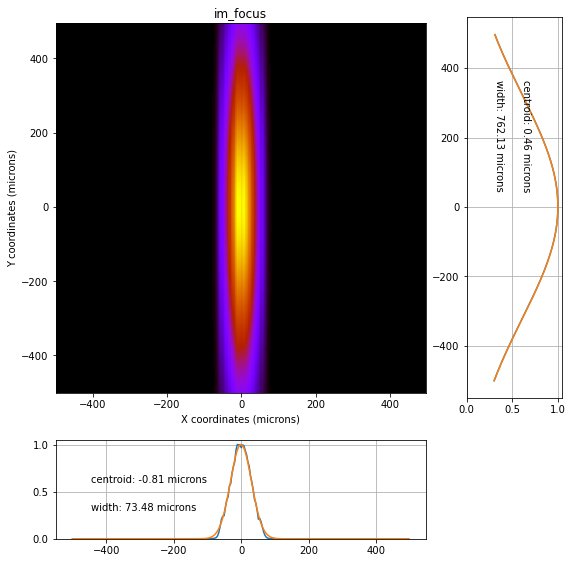

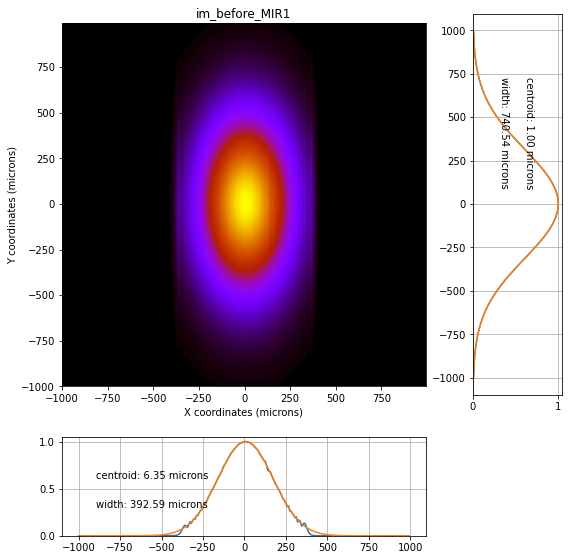

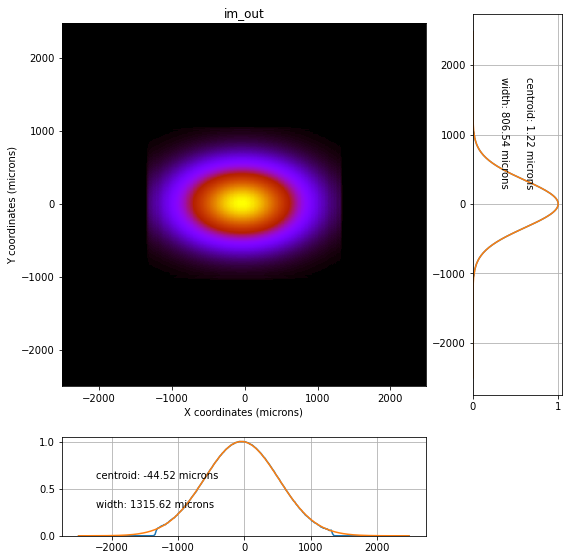

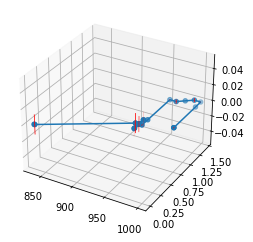

In [9]:
mono_beamline.im_focus.view_beam()
mono_beamline.im_before_MIR1.view_beam()
mono_beamline.im_out.view_beam()

ax,zs = mono_beamline.draw_beamline()

### Time domain

In [10]:
%%capture capt

#### Time domain propagation
beam_params['photonEnergy'] = E0
# pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)
pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=400e-3, N=200)

tstart = time.time()
# screen_names = ['im_after_T1', 'im_after_T2', 'im_after_HHLM1', 'im_after_HHLM2', 'im_after_HHLM3', 'im_after_HHLM4',
#     'im_after_C1','im_after_C2','im_before_MIR1','im_after_MIR1','im_focus','im_before_MIR2','im_after_MIR2','im_after_C3','im_out']

screen_names = ['im_out']

pulse.propagate(beamline=mono_beamline, screen_names=screen_names)
tfin = time.time()

In [11]:
''' diagnostics '''
c, pulse_duration0 = pulse.pulse_duration('im_out')
pulse_tilt0 = pulse.pulsefront_tilt('im_out')
spatial_chirp0 = pulse.spatial_chirp('im_out')
energy_bandwidth0 = pulse.pulse_bandwidth('im_out')

print('duration {}fs'.format(pulse_duration0))
print('tilt {}fs/um'.format(pulse_tilt0))
print('spatial chirp {}meV/um'.format(spatial_chirp0*1e3))
print('bandwidth {}meV'.format(energy_bandwidth0*1e3))

duration 152fs
tilt -0.10005340336679742fs/um
spatial chirp -0.012228820093948316meV/um
bandwidth 44.57211207046374meV


In [12]:
import winsound
winsound.Beep(1500, 1000)

### Loop for shapeError correction

In [13]:
%%capture cap
##### With Error
n_loop = 61
pulse_duration = np.zeros(n_loop)
pulse_tilt = np.zeros(n_loop)
spatial_chirp = np.zeros(n_loop)
energy_bandwidth = np.zeros(n_loop)

m2_p = np.linspace(-15,15,n_loop) + 175.332

E0 = 9481

for i in range(n_loop):
    # reset central photon energy
    beam_params['photonEnergy'] = E0

    # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
    # pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)
    pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=400e-3, N=200)
    mono_beamline = define_beamline(E0,200e-6,m2_p=m2_p[i],shape=shapeError)
    
    pulse.propagate(beamline=mono_beamline,screen_names=['im_out'])
    c, pulse_duration[i] = pulse.pulse_duration('im_out')
    pulse_tilt[i] = pulse.pulsefront_tilt('im_out')
    spatial_chirp[i] = pulse.spatial_chirp('im_out')
    energy_bandwidth[i] = pulse.pulse_bandwidth('im_out')


make path


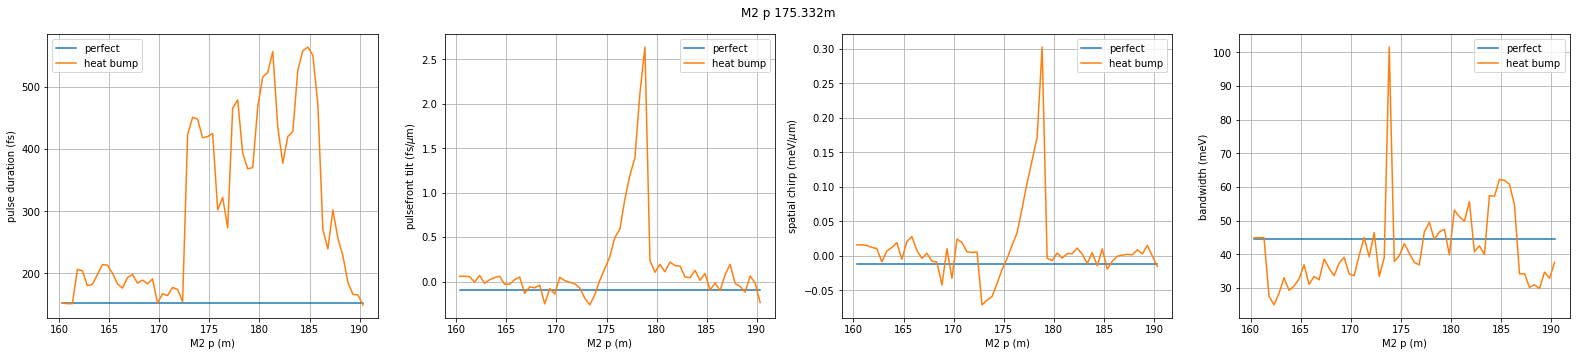

In [14]:
#### plot
dir_plot = dir_ev + 'C2/'; make_dir(dir_plot)

plt.figure(figsize=(22,5))
plt.suptitle('M2 p {}m'.format(175.332))
plt.subplot(1,4,1)
plt.plot(m2_p, np.ones_like(m2_p)*pulse_duration0,label='perfect')
plt.plot(m2_p, pulse_duration,label='heat bump')
plt.xlabel('M2 p (m)')
plt.ylabel('pulse duration (fs)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.subplot(1,4,2)
plt.plot(m2_p, np.ones_like(m2_p)*pulse_tilt0,label='perfect')
plt.plot(m2_p, pulse_tilt,label='heat bump')
plt.xlabel('M2 p (m)')
plt.ylabel(r'pulsefront tilt (fs/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.subplot(1,4,3)
plt.plot(m2_p, np.ones_like(m2_p)*spatial_chirp0*1000,label='perfect')
plt.plot(m2_p, spatial_chirp*1000,label='heat bump')
plt.xlabel('M2 p (m)')
plt.ylabel(r'spatial chirp (meV/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.subplot(1,4,4)
plt.plot(m2_p, np.ones_like(m2_p)*energy_bandwidth0*1000,label='perfect')
plt.plot(m2_p, energy_bandwidth*1000,label='heat bump')
plt.xlabel('M2 p (m)')
plt.ylabel('bandwidth (meV)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.savefig(dir_plot+'correction.png')

In [15]:
import winsound
winsound.Beep(1500, 3000)